<a href="https://colab.research.google.com/github/francianerod/Projetos-SoulCode/blob/main/Projeto_Pandas_Mongo_13_03_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Solicitação**

Escola: SoulCode Academy

Curso: Bootcamp Analista de Dados - Martech - AD1

Data de entrega: 13 de março de 2023

Professor: Igor Gondim

Alunos: Franciane Rodrigues e Gustavo Vieira

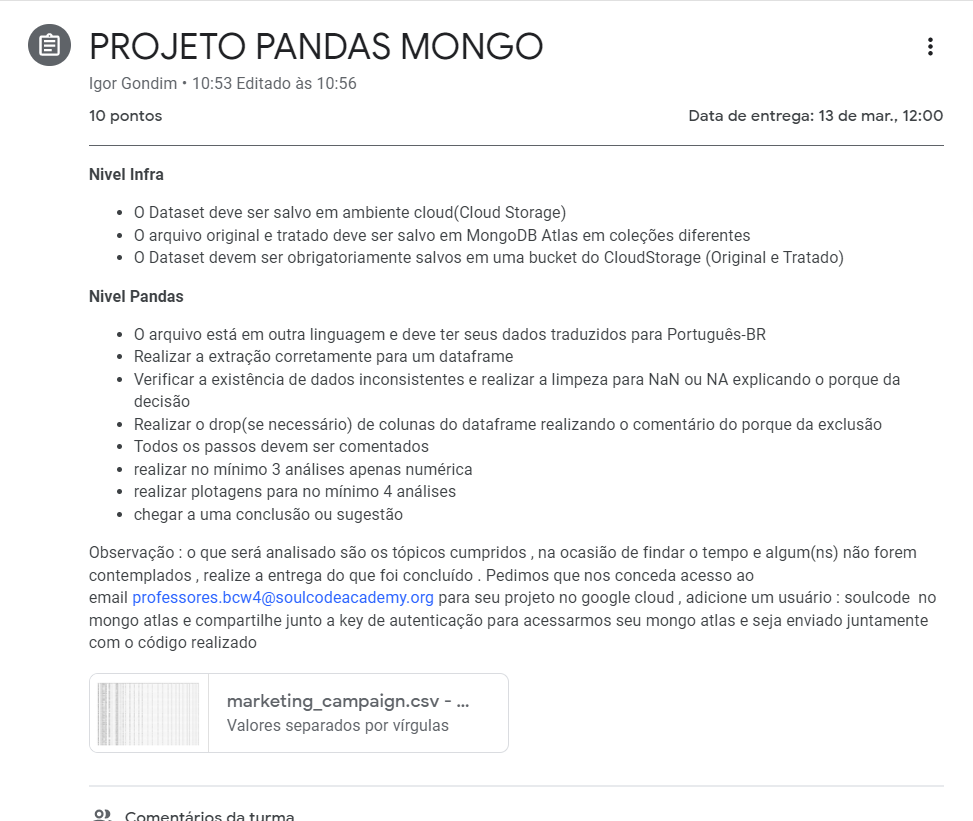

## **Informações gerais da Base de Dados**

Nesta análise buscaremos responder a algumas perguntas principais:

1. Quem são nossos clientes?
2. O que nossos clientes compram?
3. Como nossos clientes compram?
4. Qual campanha foi a mais adequada?
5. Segmentação do público premium


**Sobre este arquivo**

Esses dados foram coletados durante a campanha do ano passado (2020).

Resposta (alvo) - 1 se o cliente aceitou a oferta na última campanha, 0 caso contrário.

*   ID: ID único de cada cliente
*   Year_Birth: ano que o cliente nasceu
*   Education: nível de educação do cliente
*   Marital_status: estado civil do cliente
*   Income: renda familiar anual do cliente
*   Kidhome: número de crianças pequenas na casa do cliente
*   Teenhome: número de adolescentes na casa do cliente
*   Dt_Customer: data de cadastro do cliente na empresa
*   Recency: número de dias desde a última compra
*   MntWines: valor gasto em vinho nos últimos 2 anos
*   MntFruits: valor gasto em frutas nos últimos 2 anos
*   MntMeatProducts: valor gasto em produtos de carne nos últimos 2 anos
*   MntFishProducts: o valor gasto em produtos de peixe nos últimos 2 anos
*   MntSweetProducts: valor gasto em doces nos últimos 2 anos
*   MntGoldProds: o valor gasto em produtos de ouro nos últimos 2 anos
*   NumDealsPurchases: número de compras feitas com desconto
*   NNumWebPurchases: número de compras feitas através do site da empresa
*   NumCatalogPurchases: número de compras feitas usando o catálogo (compra de mercadorias a serem enviadas pelo correio)
*   NumStorePurchases: número de compras feitas diretamente nas lojas
*   NumWebVisitsMonth: número de visitas ao site da empresa no último mês
*   AcceptedCmp3: 1 se o cliente aceitou a oferta na 3ª campanha, 0 caso contrário
*   AcceptedCmp4: 1 se o cliente aceitou a oferta na 4ª campanha, 0 caso contrário
*   AcceptedCmp5: 1 se o cliente aceitou a oferta na 5ª campanha, 0 caso contrário
*   AcceptedCmp1: 1 se o cliente aceitou a oferta na 1ª campanha, 0 caso contrário
*   AcceptedCmp2: 1 se o cliente aceitou a oferta na 2ª campanha, 0 caso contrário
*   Complain: 1 se o cliente reclamou nos últimos 2 anos (reclamação)
*   Response: (alvo) - 1 se o cliente aceitou a oferta na última campanha, 0 caso contrário
*   Z_CostContact: custo de contato?
*   Z_Revenue: custo de receita?


Fonte: O. Parr-Rud. Business Analytics Using SAS Enterprise Guide and SAS Enterprise Miner. SAS Institute, 2014.

Acesso: https://www.kaggle.com/datasets/rodsaldanha/arketing-campaign

## **Instalação de módulos**

In [ ]:
#!pip install gcsfs
#!pip install pymongo
#!pip install pandera

## **Importação de módulos**

In [ ]:
# Importação de módulos
import os
import pymongo
import numpy as np
import pandas as pd
import pandera as pa
from pymongo import MongoClient
from google.cloud import storage

In [ ]:
# Config. do pandas
pd.set_option('display.max_columns', 100)

## **Conexões com GCP - Bucket e MongoDB**

In [ ]:
# CONFIGURANDO DA CHAVE DE SEGURANCA (Enviada com o projeto) - ACESSO O PROJETO
serviceAccount = '/content/drive/MyDrive/S3_Pandas Mongo/Projeto Pandas Mongo/francianegustavo130323-25004ff08ec3.json' 
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = serviceAccount  

In [ ]:
# Configurações Google Cloud Storage - ACESSO AO BUCKET
client = storage.Client()
bucket = client.get_bucket('pandasmongo')
bucket.blob('marketing_campaign.csv - marketing_campaign.csv - marketing_campaign.csv (1).csv')
path = 'gs://pandasmongo/bruto/marketing_campaign.csv - marketing_campaign.csv - marketing_campaign.csv (1).csv'

In [ ]:
# Configuração do MongoDB
uri = "mongodb+srv://gustavo93.vr0lcgk.mongodb.net/?authSource=%24external&authMechanism=MONGODB-X509&retryWrites=true&w=majority"
client = MongoClient(uri,
                     tls=True,
                     tlsCertificateKeyFile='/content/drive/MyDrive/S3_Pandas Mongo/Projeto Pandas Mongo/chaves/X509-cert-444977439393327391.pem',
                     )

db = client['pandasmongo1']
collection = db['brutos']

In [ ]:
doc_count = collection.count_documents({})
print(doc_count)

## **EXTRAÇÃO**

In [ ]:
# Abertura da base de dados e cópia de segurança (bucket)
df = pd.read_csv(path,sep=',',encoding='ISO-8859-1')
dfback = df.copy()

In [ ]:
# Conversão para colocar no MongoDB
df_dict = df.to_dict("records")
collection.insert_many(df_dict)

In [ ]:
# Checagem de valores no MongoDB
collection.count_documents({})

In [ ]:
# Checagem da coleção do MongoDB
for x in collection.find():
  print(x)

## **Pré-Análise**

In [ ]:
# Verificação das colunas
df.info()

In [ ]:
# Observação da base de dados
df

## **TRANSFORMAÇÃO**

**Mudanças gerais no dataframe**  

*   Tradução de colunas
*   Tradução de categorias dentro das colunas:
    *   educacao: Tradução de categoria
    *   estado_civil: Tradução de categoria
*   Mudar o número 0 e 1 para as palavras "Não" e "Sim", respectivamente.
*   Data de cadastro: transformação para datetime
*   Renda anual apresentou dados incompletos (averiguação)


In [ ]:
# Tradução de colunas 
df.rename(columns={'Year_Birth': 'ano_nasc',
                   'Education': 'educacao',
                   'Marital_Status':'estado_civil',
                   'Income': 'renda_anual',
                   'Kidhome': 'qtd_crianca',
                   'Teenhome': 'qtd_adolescente', 
                   'Dt_Customer': 'data_cadastro',
                   'Recency': 'n_dias_ultima_compra',
                   'MntWines': 'vinho',
                   'MntFruits': 'fruta',
                   'MntMeatProducts': 'carne',
                   'MntFishProducts': 'peixe',
                   'MntSweetProducts': 'doce',
                   'MntGoldProds': 'pdt_ouro',
                   'NumDealsPurchases': 'n_desconto_compras',
                   'NumWebPurchases': 'n_web_compras',
                   'NumCatalogPurchases': 'n_catalog_compras',
                   'NumStorePurchases': 'n_loja_compras',
                   'NumWebVisitsMonth': 'n_visit_web',
                   'AcceptedCmp3': 'aceitoCmp_3',
                   'AcceptedCmp4': 'aceitoCmp_4',
                   'AcceptedCmp5': 'aceitoCmp_5',
                   'AcceptedCmp1': 'aceitoCmp_1',
                   'AcceptedCmp2': 'aceitoCmp_2',
                   'Complain': 'reclamacao',
                   'Z_CostContact': 'custocontato',
                   'Z_Revenue': 'receita',
                   'Response': 'ult_aceitoCmp',
                   },
                   inplace = True)

**Informativo sobre estado civil:**

*   **Absurd:** Não há um status civil conhecido como "Absurd" em português. Pode ser um erro de digitação ou uma referência a um status civil fictício.
*   **YOLO:** "You Only Live Once" é uma expressão em inglês que significa "Você só vive uma vez". Não é um status civil em português, mas pode ser usado como uma referência a um estilo de vida que valoriza a aventura e a experiência acima de tudo.


In [ ]:
# Verificação de categorias
print(sorted(pd.unique(df['educacao'])))
print('----------------------------------')
print(sorted(pd.unique(df['estado_civil'])))
print('----------------------------------')

In [ ]:
# Tradução das categorias
df.loc[df.educacao == 'Basic',          ['educacao']] = 'BÁSICO'
df.loc[df.educacao == 'Graduation',     ['educacao']] = 'GRADUAÇÃO'
df.loc[df.educacao == '2n Cycle',       ['educacao']] = 'ESPECIALIZAÇÃO'
df.loc[df.educacao == 'Master',         ['educacao']] = 'MESTRADO'
df.loc[df.educacao == 'PhD',            ['educacao']] = 'DOUTORADO'

In [ ]:
# Tradução das categorias
df.loc[df.estado_civil == 'Alone',       ['estado_civil']] = 'SOZINHO'
df.loc[df.estado_civil == 'Single',      ['estado_civil']] = 'SOLTEIRO(A)'
df.loc[df.estado_civil == 'Together',    ['estado_civil']] = 'JUNTO(A)'
df.loc[df.estado_civil == 'Married',     ['estado_civil']] = 'CASADO(A)'
df.loc[df.estado_civil == 'Divorced',    ['estado_civil']] = 'DIVORCIADO(A)'
df.loc[df.estado_civil == 'Widow',       ['estado_civil']] = 'VIÚVO(A)'
df.loc[df.estado_civil == 'Absurd',      ['estado_civil']] = 'DESCONHECIDO'

In [ ]:
# Transformando os dados 0 e 1 do dataframe
df['aceitoCmp_1'  ] = df['aceitoCmp_1'].replace({0 : "Não", 1: "Sim"})
df['aceitoCmp_2'  ] = df['aceitoCmp_2'].replace({0 : "Não", 1: "Sim"})
df['aceitoCmp_3'  ] = df['aceitoCmp_3'].replace({0 : "Não", 1: "Sim"})
df['aceitoCmp_4'  ] = df['aceitoCmp_4'].replace({0 : "Não", 1: "Sim"})
df['aceitoCmp_5'  ] = df['aceitoCmp_5'].replace({0 : "Não", 1: "Sim"})
df['reclamacao'   ] = df['reclamacao' ].replace({0 : "Não", 1: "Sim"})
df['ult_aceitoCmp'] = df['ult_aceitoCmp'].replace({0 : "Não", 1: "Sim"})

In [ ]:
# Tranformando as datas
df['data_cadastro'] = df['data_cadastro'].astype(str)
df['data_cadastro'] = pd.to_datetime(df['data_cadastro'], format='%d-%m-%Y')

In [ ]:
# Verificando quantidade e se são valores únicos na coluna de ID
print(len(df.ID.unique()))
print(df.ID.is_unique)

In [ ]:
# Verificar a quantidade de valores Nulos, ausentes, etc
print(df.isna().sum())

In [ ]:
# Transformando valores 0.0 para np.NaN porque o MongoDB entende no formato np.NaN
df['renda_anual'].replace(0.0, np.nan, inplace=True)

In [ ]:
# Verificação de valores duplicados
df.duplicated().sum()

In [ ]:
# Cálculo se o cliente tem filho ou não
df['pais'] = (df['qtd_crianca'] + df['qtd_adolescente'] > 0).astype(int)
df['pais'] = df['pais'].replace({0 : "Não", 1: "Sim"})

In [ ]:
# Calculo sobre a idade do cliente
df['idade'] = 2020 - df['ano_nasc']

In [ ]:
# Retirando a coluna de 'ano_nasc', 'ID','custocontato','receita'
# Coluna ID serviu para checar se os clientes são únicos, não agregando posteriormente nas análises
# ano de nascimento foi retirada porque calculamos a idade
# custocontrato e receita possui valores que não agregariam na nossa pergunta de negócio.
df.drop(['ID','ano_nasc', 'custocontato','receita'],axis=1,inplace=True)
df.dtypes

## **Validação SCHEMA**

In [ ]:
# Verificação da qualidade do conjunto de dados
schema = pa.DataFrameSchema(columns = {'educacao':pa.Column(pa.String),
                                       'estado_civil':pa.Column(pa.String),
                                       'renda_anual':pa.Column(pa.Float, nullable=True),
                                       'qtd_crianca':pa.Column(pa.Int),
                                       'qtd_adolescente':pa.Column(pa.Int),
                                       'data_cadastro':pa.Column(pa.DateTime),                        
                                       'n_dias_ultima_compra':pa.Column(pa.Int),
                                       'vinho':pa.Column(pa.Int),
                                       'fruta':pa.Column(pa.Int),
                                       'carne':pa.Column(pa.Int),
                                       'peixe':pa.Column(pa.Int),
                                       'doce':pa.Column(pa.Int),
                                       'pdt_ouro':pa.Column(pa.Int),
                                       'n_desconto_compras':pa.Column(pa.Int),
                                       'n_web_compras':pa.Column(pa.Int),
                                       'n_catalog_compras':pa.Column(pa.Int),
                                       'n_loja_compras':pa.Column(pa.Int),
                                       'n_visit_web':pa.Column(pa.Int),
                                       'aceitoCmp_3':pa.Column(pa.String),
                                       'aceitoCmp_4':pa.Column(pa.String),
                                       'aceitoCmp_5':pa.Column(pa.String),
                                       'aceitoCmp_1':pa.Column(pa.String),
                                       'aceitoCmp_2':pa.Column(pa.String),
                                       'reclamacao':pa.Column(pa.String),
                                       'ult_aceitoCmp':pa.Column(pa.String),
                                       'idade':pa.Column(pa.Int),
                                       'pais':pa.Column(pa.Int)
                                      }
                           )

In [ ]:
# Backup do dataframe tratado e validado
dftratado = df.copy()

## **CARREGAMENTO**

In [ ]:
df.to_csv('marketing_tratado.csv', index=False) # salva localmente

In [ ]:
df.to_csv('gs://pandasmongo/tratado/camp_marketing_tratado.csv', index=False) # salva no bucket

In [ ]:
# Carregamento no MongoDB
db2 = client['pandasmongo1']
collection2 = db2['tratado']
collection2.count_documents({})

In [ ]:
# Connversão de dados para MongoDB
df_dict = df.to_dict("records")
collection2.insert_many(df_dict)

In [ ]:
# Contagem de dados: verificação
collection2.count_documents({})

In [ ]:
# Checagem da coleção
for x in collection2.find():
  print(x)

## **Análises**

### **1. QUEM SÃO NOSSOS CLIENTES? (GERAL)** ###



*   Idade
*   Educação
*   Estado Civil
*   Tem filhos?
*   Renda




In [ ]:
# IDADE
# As 10 Idades mais frequentes
df.groupby(['idade']).size().sort_values(ascending=False).head(10)

In [ ]:
# Visualização da idade dos clientes
df.groupby(['idade'],dropna=False).size().sort_values(ascending=False).plot.bar(figsize=(20,8),xlabel='Idade',ylabel='Quantidade de pessoas', color=['DarkViolet'])

In [ ]:
# EDUCAÇÃO
# Checando o nível de educação dos clientes
df.groupby(['educacao']).size().sort_values(ascending=False)

In [ ]:
# Calculo de porcentagem
grad = (1127/2240)*100
dout = (486/2240)*100
mest = (370/2240)*100
espe = (206/2240)*100
basi = (54/2240)*100

# Mostrando os resultados
print('Os graduados representam ', round(grad,1),'%')
print('Os doutores  representam ', round(dout,1),'%')
print('Os mestres representam ', round(mest,1),'%')
print('Os especialistas representam ', round(espe,1),'%')
print('Aqueles com educação básica representam ', round(basi,1),'%')

In [ ]:
# Visualização do gráfico da educação
df.groupby(['educacao']).size().sort_values(ascending=False).plot.barh(figsize=(12,8),color=['orange'])

In [ ]:
# ESTADO CIVIL
df.groupby(['estado_civil']).size().sort_values(ascending=False)

In [ ]:
# Cálculo de porcentagem do estado civil
casado = (864/2240)*100
junto = (580/2240)*100
solt = (480/2240)*100
div = (232/2240)*100
viuv = (77/2240)*100
sozi = (3/2240)*100
desc = (2/2240)*100
YOLO = (2/2240)*100

# Mostrando os resultados
print('Casados(as) representam ', round(casado,1),'%')
print('Junto(a)  representam ', round(junto,1),'%')
print('Solteiro(a) representam ', round(solt,1),'%')
print('Divorciado(a) representam ', round(div,1),'%')
print('Viúvo(a) representam ', round(viuv,1),'%')
print('Sozinho(a) representam ', round(sozi,1),'%')
print('Não informado representam ', round(desc,1),'%')
print('YOLO representam ', round(YOLO,1),'%')

In [ ]:
# Visualização do estado civil
df.groupby(['estado_civil']).size().sort_values(ascending=False).plot.barh(figsize=(12,8), color=['red'])

In [ ]:
# FILHOS
df.groupby(['pais'],dropna=False).size().sort_values(ascending=False)

In [ ]:
# Percentual de clientes com filhos
colors = ['#FA8072', '#FFDAB9']
df.groupby(['pais'],dropna=False).size().sort_values(ascending=False).plot(kind='pie', ylabel= 'Percentual de clientes com filhos', figsize=(12, 8), autopct='%1.0f%%', startangle=90, colors=colors)

In [ ]:
# RENDA
# Renda anual máxima e mínima dos clientes
print('A renda anual mínima é: ', df['renda_anual'].min(), 'dólares')
print('A renda anual máxma é: ',  df['renda_anual'].max(), 'dólares')

In [ ]:
# Visualização da renda da maioria dos clientes sem os outliers via showfliers=False.
df.renda_anual.plot.box(vert=False, 
                        showfliers=True, 
                        grid=True, 
                        figsize=(12,8), 
                        patch_artist=True, 
                        medianprops=dict(color='black'), 
                        capprops=dict(color='black'), 
                        boxprops=dict(facecolor='Gold', color='black'),
                       )

In [ ]:
# Visualização da renda da maioria dos clientes sem os outliers via showfliers=False.
df.renda_anual.plot.box(vert=False, 
                        showfliers=False, 
                        grid=True, 
                        figsize=(12,8), 
                        patch_artist=True, 
                        medianprops=dict(color='black'), 
                        capprops=dict(color='black'), 
                        boxprops=dict(facecolor='Pink', color='black'),
                       )

### **2. O QUE NOSSOS CLIENTES COMPRAM? (GERAL)** ###

In [ ]:
# Valor gasto nos iten  nos últimos 2 anos
soma = df[['vinho', 'fruta', 'carne','peixe','doce']].sum().sort_values(ascending=False)
print(soma)
print('O valor arrecadado em compras nos últimos 2 anos foi de: ', soma.sum())

In [ ]:
# Cálculo de porcentagem forma 2
# Declarando as entradas do código
total_vendas = 1258379
gastos = {'vinho': 680816,
          'carne': 373968,
          'peixe': 84057,
          'doce': 60621,
          'fruta': 58917
          }

# Calculando as porcentagens
porcentagens = {}
for categoria, valor in gastos.items():
    porcentagem = (valor / total_vendas) * 100
    porcentagens[categoria] = porcentagem

# Mostrando os resultados
for categoria, porcentagem in porcentagens.items():
    print(f'O valor gasto em {categoria} nos últimos 2 anos corresponde a {porcentagem:.1f}%')

In [ ]:
# Visualização
data = {'vinho': 680816, 'carne': 373968, 'peixe': 84057, 'doce': 60621, 'fruta': 58917}
series = pd.Series(data)
series.plot.bar(figsize=(12,8),color=['Maroon'])

### **3. COMO NOSSOS CLIENTES COMPRAM? (GERAL)** ###

In [ ]:
# COMPRAS
soma = df[['n_web_compras', 'n_catalog_compras', 'n_loja_compras']].sum().sort_values(ascending=False)
print(soma)
print('Total de compras: ', soma.sum())

In [ ]:
# Cálculo de porcentagem forma 2
# Declarando as entradas do código
total_vendas = 28083
locais = {'n_loja_compras': 12970,
          'n_web_compras': 9150,
          'n_catalog_compras': 5963,
          }

# Calculando as porcentagens
porcentagens = {}
for categoria, valor in locais.items():
    porcentagem = (valor / total_vendas) * 100
    porcentagens[categoria] = porcentagem

# Mostrando os resultados
for categoria, porcentagem in porcentagens.items():
    print(f'As compras são origem na(o) {categoria} corresponde a {porcentagem:.1f}% das vendas')

In [ ]:
colors = ['#DAA520', 'RosyBrown', 'Chocolate']
df[['n_web_compras', 'n_catalog_compras', 'n_loja_compras']].sum().sort_values(ascending=False).plot.pie( figsize=(12, 8), 
                                                                                                          autopct='%1.0f%%', 
                                                                                                          startangle=0, 
                                                                                                          colors=colors,
                                                                                                          ylabel='Tráfego de compras')

### **4. QUAL CAMPANHA FOI  A MAIS ADEQUADA? (GERAL)**

In [ ]:
# Avaliando as campanhas: avalia se o cliente aceitou a oferta na (1°,2°,..., última campanha) ou não
print(df.groupby(['aceitoCmp_1'],dropna=False).size().sort_values(ascending=False))
print('\n--------------------------------------------------------------------')

print(df.groupby(['aceitoCmp_2'],dropna=False).size().sort_values(ascending=False))
print('\n--------------------------------------------------------------------')

print(df.groupby(['aceitoCmp_3'],dropna=False).size().sort_values(ascending=False))
print('\n--------------------------------------------------------------------')

print(df.groupby(['aceitoCmp_4'],dropna=False).size().sort_values(ascending=False))
print('\n--------------------------------------------------------------------')

print(df.groupby(['aceitoCmp_5'],dropna=False).size().sort_values(ascending=False))
print('\n--------------------------------------------------------------------')

print(df.groupby(['ult_aceitoCmp'],dropna=False).size().sort_values(ascending=False))

In [ ]:
# Visualização dos aceites das campanhas
data = {'aceitoCmp_1': 144, 'aceitoCmp_2': 30, 'aceitoCmp_3': 163, 'aceitoCmp_4': 167, 'aceitoCmp_5': 163, 'ult_aceitoCmp': 334}
data = pd.Series(data)
data.plot.bar(figsize=(12,8),color=['DarkCyan'])

In [ ]:
# Segmentando a última campanha
filtro_sim = df.loc[df.ult_aceitoCmp == 'Sim']
filtro_sim

In [ ]:
# Quais caracteriticas de quem aceitou a última oferta?
print(filtro_sim.groupby(['educacao','ult_aceitoCmp']).size().sort_values(ascending=False))
print('\n--------------------------------------------------------------------')
print(filtro_sim.groupby(['estado_civil','ult_aceitoCmp']).size().sort_values(ascending=False))
print('\n--------------------------------------------------------------------')
print(filtro_sim.groupby(['idade','ult_aceitoCmp']).size().sort_values(ascending=False).head(12))
print('\n--------------------------------------------------------------------')
print(filtro_sim.groupby(['pais','ult_aceitoCmp']).size().sort_values(ascending=False))
print('\n--------------------------------------------------------------------')

### **5. SEGMENTAÇÃO DO PÚBLICO PREMIUM**

In [ ]:
# Visualização da renda da maioria dos clientes sem os outliers via showfliers=False.
df.renda_anual.plot.box(vert=False, 
                        showfliers=True, 
                        grid=True, 
                        figsize=(12,8), 
                        patch_artist=True, 
                        medianprops=dict(color='black'), 
                        capprops=dict(color='black'), 
                        boxprops=dict(facecolor='Gold', color='black'),
                       )

In [ ]:
# Análise feita dos consumidores que possuem renda anual acima de 68522.00 dolares 
df_rico = df.loc[df.renda_anual > 68522.0]

In [ ]:
# Quantos clientes premium temos?
print('Tamanho da base filtrada é: ', df_rico.shape)
print('Tamanho da base original é: ', df.shape)

In [ ]:
# Do total de 2240, quanto representam esses clientes?
print('A porcentagem de clientes do tipo premium é de: {:.2f}%'.format(554/2240*100))

In [ ]:
# CARACTERIZAÇÃO DO CLIENTE
print(df_rico.groupby(['educacao'],dropna=False).size().sort_values(ascending=False))
print('\n--------------------------------------------------------------------')
print(df_rico.groupby(['estado_civil'],dropna=False).size().sort_values(ascending=False))
print('\n--------------------------------------------------------------------')
print(df_rico.groupby(['idade'],dropna=False).size().sort_values(ascending=False).head(10))
print('\n--------------------------------------------------------------------')

In [ ]:
# Quantidade de filhos
colors = ['#FA8072', '#B0E0E6']
df_rico.groupby(['pais'],dropna=False).size().sort_values(ascending=False).plot(kind='pie', ylabel= 'Percentual de clientes premium com filhos', figsize=(12, 8), autopct='%1.0f%%', startangle=90, colors=colors)

In [ ]:
# COMPRAS
# Valor gasto nos iten  nos últimos 2 anos
soma = df_rico[['vinho', 'fruta', 'carne','peixe','doce']].sum().sort_values(ascending=False)
print(soma)
print('O valor arrecadado em compras nos últimos 2 anos foi de: ', soma.sum())

In [ ]:
# Cálculo de porcentagem forma 2
# Declarando as entradas do código
total_vendas = 712085
gastos = {'vinho': 351656,
          'carne': 241538,
          'peixe': 49159,
          'doce': 36052,
          'fruta': 33680
          }

# Calculando as porcentagens
porcentagens = {}
for categoria, valor in gastos.items():
    porcentagem = (valor / total_vendas) * 100
    porcentagens[categoria] = porcentagem

# Mostrando os resultados
for categoria, porcentagem in porcentagens.items():
    print(f'O valor gasto em {categoria} nos últimos 2 anos corresponde a {porcentagem:.1f}%')

In [ ]:
print('O valor arrecadado em compras nos últimos 2 anos desse público representa:', round((712085/1258379)*100,1), '%')

In [ ]:
# COMPRAS
soma = df_rico[['n_web_compras', 'n_catalog_compras', 'n_loja_compras']].sum().sort_values(ascending=False)
print(soma)
print('Total de compras: ', soma.sum())

In [ ]:
# Cálculo de porcentagem forma 2
# Declarando as entradas do código
total_vendas = 10705
locais = {'n_loja_compras': 4619,
          'n_catalog_compras': 3157,
          'n_web_compras ': 2929,
          }

# Calculando as porcentagens
porcentagens = {}
for categoria, valor in locais.items():
    porcentagem = (valor / total_vendas) * 100
    porcentagens[categoria] = porcentagem

# Mostrando os resultados
for categoria, porcentagem in porcentagens.items():
    print(f'As compras são origem na(o) {categoria} corresponde a {porcentagem:.1f}% das vendas')

In [ ]:
#CAMPANHAS
# Avaliando as campanhas do publico premium: avalia se o cliente aceitou a oferta na (1°,2°,..., última campanha) ou não
print(df_rico.groupby(['aceitoCmp_1'],dropna=False).size().sort_values(ascending=False))
print('\n--------------------------------------------------------------------')

print(df_rico.groupby(['aceitoCmp_2'],dropna=False).size().sort_values(ascending=False))
print('\n--------------------------------------------------------------------')

print(df_rico.groupby(['aceitoCmp_3'],dropna=False).size().sort_values(ascending=False))
print('\n--------------------------------------------------------------------')

print(df_rico.groupby(['aceitoCmp_4'],dropna=False).size().sort_values(ascending=False))
print('\n--------------------------------------------------------------------')

print(df_rico.groupby(['aceitoCmp_5'],dropna=False).size().sort_values(ascending=False))
print('\n--------------------------------------------------------------------')

print(df_rico.groupby(['ult_aceitoCmp'],dropna=False).size().sort_values(ascending=False))

In [ ]:
# Visualização dos aceites das campanhas do público premium
data = {'aceitoCmp_1': 121, 'aceitoCmp_2': 16, 'aceitoCmp_3': 43, 'aceitoCmp_4': 77, 'aceitoCmp_5': 153, 'ult_aceitoCmp': 149}
data = pd.Series(data)
data.plot.bar(figsize=(12,8),color=['MediumSlateBlue'])

## **Conclusões**

**1. Quem são nossos clientes?**

São pessoas entre 43 a 61 anos, com grau de escolaridade alto (graduação, mestrado e doutorado). Cerca de 64% são  casais, seguido pelos solteiros em torno de 25%. 72% dos clientes possuem filhos e a renda  varia entre 38-70 mil dolares/ano (3000-6000 dolares/mês aproximadamente).

**2. O que nossos clientes compram?**

Os produtos mais vendidos nos últimos 2 anos são vinho e carne com 83,8% das receitas.

**3. Como nossos clientes compram?**

Aproximadamente,80% das compras são feitas na loja e na internet.


**4. Qual campanha foi a mais adequada?**

A última campanha foi aceita pela maioria de clientes solteiros como casados, com graduação e doutorado e idades entre 45 a 71 anos, sendo essa última campanha a mais efetiva. Recomenda-se manter a estratégia da equipe de marketing

**5. Segmentação do público premium**

Cerca de 25% dos clientes ganham acima de 68522 dolares anual. São clientes que em sua grande maioria possui graduação ou doutorado, são casados, não possuem filhos e idade entre 43-62 anos. O valor arrecadado em compras nos últimos 2 anos por esse seleto público representa 56.6% das vendas com 83% das compras são em vinhos e carne. Cerca de 72% dessse público compram na loja e por catalogo. As estratégias das campanhas 1, 4 e 5 tiveram mais aceite desse seleto grupo;
